# Necessary Imports

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
use_cuda=True
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
torch.manual_seed(2)
np.random.seed(2)

# Data Loading and Processing

In [0]:
real_train=np.load("/content/drive/My Drive/CelebA/image_array_10000.npy")
fake_train=np.load("/content/drive/My Drive/CelebA/image_array_10000_fakes.npy")

if real_train.shape[1:]==(64, 64, 3):
  array_real = np.transpose(real_train, (0, 1, 3, 2))
  array_real = np.transpose(array_real, (0, 2, 1, 3))
else:
  array_real=real_train

if fake_train.shape[1:]==(64, 64, 3):

  array_fake = np.transpose(fake_train, (0, 1, 3, 2))
  array_fake = np.transpose(array_fake, (0, 2, 1, 3))
else:
  array_fake=fake_train

In [0]:
train_x=np.concatenate([array_real, array_fake])
train_y=np.concatenate([np.zeros(len(array_real)), np.ones(len(array_fake))])

x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, stratify=train_y, test_size=0.2, shuffle=True)


In [0]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision
import torchvision.transforms as transforms


class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),  transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])

transform_norm = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])

dataset = MyDataset(x_train, y_train, transform=transform)
dataloader = DataLoader(dataset, 50, shuffle=True)

# Training and Validation Functions

In [0]:
#Main Training code

#Train function returns the training data accuracy, dev data accuracy, and loss for each epoch. This was needed for plotting the graphs.

def train(model ,optimiser, criterion, num_epochs, scheduler_present=False, load=False, save=False):
  train_acc=[]
  val_acc=[]
  loss_data=[]
  
  start=0
  
  if load:
    checkpoint = torch.load(PATH) #set Path here for loading data
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start = checkpoint['epoch']
    loss = checkpoint['loss']
    model.train()

  for epoch in range(start, num_epochs):

    for local_X, local_Y in dataloader:
      local_X, local_Y= local_X.cuda(), local_Y.cuda()
      optimizer.zero_grad()

      outputs=model(local_X)
      loss=criterion(outputs, local_Y)
      loss.backward()

      optimizer.step()
    
    if scheduler_present:
      scheduler.step()
    
    tr=model_accuracy(model, x_train, y_train, 50)
    val=model_accuracy(model, x_test, y_test, 50)
    
    train_acc.append(tr)
    val_acc.append(val)
    loss_data.append(loss.item())

    if epoch%10==0:
      print("Epoch:", epoch, loss.item(), "Train Acc:", tr, "Val Acc:", val)
    

    #Saving the Model (Current path in Google Drive)
    
    if save and epoch%50==0:
      torch.save({'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss,}, "/content/drive/My Drive/DL_CIFAR_"+str(epoch)) #set path here for saving data to desired location
  
  return train_acc, val_acc, loss_data


#Model Accuracy Calculator
#Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

def model_accuracy(model, data_x, data_y, batch_size):

  correct = 0
  total = 0

  dataset_check = MyDataset(data_x, data_y, transform=transform_norm)
  dataloader_check = DataLoader(dataset_check, 50, shuffle=False)
  with torch.no_grad():
      for local_X, local_Y in dataloader_check:
          local_X, local_Y= local_X.cuda(), local_Y.cuda()
          outputs = model(local_X)
          _, predicted = torch.max(outputs.data, 1)
          total += local_Y.size(0)
          correct += (predicted == local_Y).sum().item()

  return 100 * correct / total


# Convolution Neural Network Model

In [0]:

class CNN_Model_2(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1= torch.nn.Conv2d(3, 16, 7)
    self.conv2= torch.nn.Conv2d(16, 16, 3)
    self.pool= torch.nn.MaxPool2d(2,2)
    self.drop= torch.nn.Dropout(p=0.25)
    self.conv_batchnorm=torch.nn.BatchNorm2d(16)
    self.linear1=nn.Linear(11664, 2)
    

  def forward(self, x):
    x=self.pool(F.relu(self.conv_batchnorm(self.conv1(x))))
    x=F.relu(self.conv_batchnorm(self.conv2(x)))
    x=x.view(-1, 11664)

    
    x=self.drop(x)
    x=(self.linear1(x))

    return x

# Training 

In [0]:

#Run Model 2

model=CNN_Model_2()
model.cuda()

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0005) #regularisation l2
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

num_epochs=50

scheduler_present=True

#Loading and Saving Data (Needs drive Mounting)
load_data=False
save_data=False

train_acc, val_acc, loss_data=train(model, optimizer, criterion, num_epochs, scheduler_present, load_data, save_data)

Epoch: 0 0.0 Train Acc: 99.9375 Val Acc: 99.925
Epoch: 10 0.0 Train Acc: 99.975 Val Acc: 99.95
Epoch: 20 0.05615462362766266 Train Acc: 99.95 Val Acc: 99.975
Epoch: 30 0.0 Train Acc: 99.9875 Val Acc: 100.0
Epoch: 40 0.0 Train Acc: 99.9875 Val Acc: 99.975


# Evaluation on New Test Data

In [0]:
#Load Data
nvidia_fakes = np.load('/content/drive/My Drive/CelebA/image_fake_array_10000.npy')
real_images = np.load('/content/drive/My Drive/CelebA/image_array_20000.npy')[:10000]

if nvidia_fakes.shape[1:]==(64, 64, 3):
  nvidia_fake_array = np.transpose(nvidia_fakes, (0, 1, 3, 2))
  nvidia_fake_array = np.transpose(nvidia_fake_array, (0, 2, 1, 3))
else:
  nvidia_fake_array=nvidia_fakes

if real_images.shape[1:]==(64, 64, 3):
  real_images_array = np.transpose(real_images, (0, 1, 3, 2))
  real_images_array = np.transpose(real_images_array, (0, 2, 1, 3))
else:
  real_images_array=real_images

#Create a mixture of real and Nvidia Fakes

test_x=np.concatenate([nvidia_fake_array, real_images_array])
test_y=np.concatenate([np.ones(len(nvidia_fake_array)), np.zeros(len(real_images_array))])

#Create a dataloader
dataset_test=MyDataset(x_test, y_test, transform=transform_norm)
dataloader_test=torch.utils.data.DataLoader(dataset_test, 50, shuffle=True)

In [0]:
#Check Accuracy
model_accuracy(model, x_test, y_test, 50)

45.3

# Generate Plots

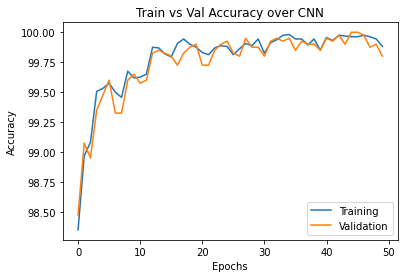

In [0]:
plt.title("Train vs Val Accuracy over CNN")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(len(tr_acc)), tr_acc, label="Training")
plt.plot(range(len(val_acc)), val_acc, label="Validation")
plt.legend();

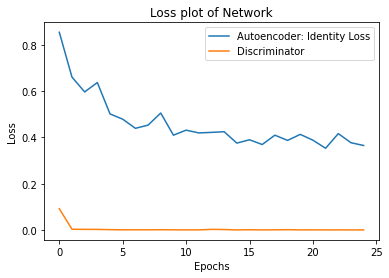

In [0]:
plt.title("Loss plot of Network")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(loss)), loss, label='Loss');
plt.legend();